Neural Networks Assignment

In [31]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from tqdm import notebook
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from statistics import mean

random.seed(234558)

num_epochs = 10
input_size = 28*28

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA RTX A4000


##Importing the dataset: Fashion MNIST

In [32]:
## Downloading and loading training and testing data

train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)

Getting random (seeded) examples of each class: 
1. t-shirt/top
2. trouser
3. pullover
4. dress
5. coat
6. sandal
7. shirt
8. sneaker
9. bag
10. ankle boot

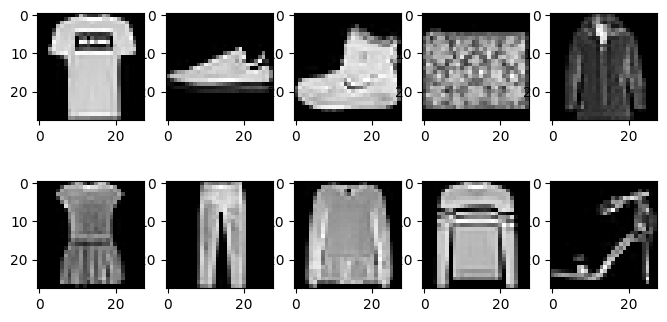

In [33]:
image_list = []
seen_labels = []
for i, (images, labels) in enumerate(train_dataset):
  if len(seen_labels) == 10:
    break
  elif labels not in seen_labels:
    image_list.insert(labels, images[0])
    seen_labels.append(labels)

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
for i in range(10):
  ax[i % 2, i % 5].imshow(image_list[i], cmap='gray', vmin=0, vmax=1)
plt.show()

To find if our classes are evenly distributed or not, I'll grab the frequency of each. 

This should only take about 10 seconds on colab.

In [34]:
class_frequency = [0,0,0,0,0,0,0,0,0,0]
print(class_frequency)
for i, (images, labels) in notebook.tqdm(enumerate(train_dataset)):
  class_frequency[labels] = class_frequency[labels] + 1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0it [00:00, ?it/s]

In [35]:
print(class_frequency)
print(len(train_dataset))

[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
60000


Our dataset of 60,000 is evenly distributed into 10 lots of 6,000

## Helper Functions

In [36]:
def trainModel(num_epochs, model, data, criterion, optimizer):
  model.train() #model in train mode
  epochs = notebook.tqdm(range(num_epochs))

  loss_list = []

  for epoch in epochs:
    for i, (images, labels) in enumerate(data):
      # move tensors to device (CPU or GPU)
      images = images.to(device)
      labels = labels.to(device)

      #forward pass
      predictions = model(images)
      loss = criterion(predictions, labels)

      #backward pass, optimise
      loss.backward() #backprop the loss
      
      optimizer.step()
      optimizer.zero_grad()

      if (i + 1) % 10 == 0: #update progress bar every 10 batches
        epochs.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{len(data)}], Loss: {loss.item():.4f}")
        loss_list.append(loss.item()) #may have to make a running loss
  return loss_list

In [37]:
def testModel(model, data):
  model.eval() # model in evaluation mode
  
  pred_list = []
  accuracy_list = []

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in notebook.tqdm(data):
      images = images.to(device)
      labels = labels.to(device)

      predictions = model(images)
      _, predictions = torch.max(predictions.data, 1)
      total += labels.size(0)
      correct += (predictions == labels).sum().item()
      
      pred_list.append(predictions.cpu())
      accuracy_list.append((predictions == labels).sum().item() / labels.size(0))

  print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")
  return pred_list, accuracy_list

In [38]:
def modelMetrics(predictions, labels, running_loss, running_accuracy):
  if predictions[0].is_cuda:  # if running on a GPU, convert back to regular CPU tensors so that sklearn can parse 
    predictions = [pred.cpu() for pred in predictions]
  cm = confusion_matrix(labels, predictions)
  
  plot_curves(running_loss, running_accuracy)
  #plot_confusion_matrix(cm) #not really that useful comparatively, since it shows a 10x10 grid

  return cm

In [39]:
def plot_curves(loss, accuracy):
  # Loss Curve
  plt.subplot(2, 1, 1)
  plt.plot(loss, color='b', label='loss')

  plt.plot(moving_average(loss, 10), color='g', label='trend')
  plt.ylim((0, 2.5))
  plt.title("Loss")

  # Accuracy Curve
  plt.subplot(2, 1, 2)
  plt.plot(accuracy, color='b', label='accuracy')
  plt.plot(moving_average(accuracy, 10), color='g', label='trend')
  plt.ylim((0, 1))
  plt.title("Accuracy")

  plt.tight_layout()
  plt.show()

In [40]:
def plot_confusion_matrix(cm):
  ConfusionMatrixDisplay(cm).plot()

In [41]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [42]:
def ignore_batches(raw_predictions):
  all_predictions = [item for batch in raw_predictions for item in batch]
  if all_predictions[0].is_cuda:
    all_predictions = [pred.cpu() for pred in all_predictions] 
  return all_predictions

In [46]:
def run_experiment(lr=0.001, optimiser='adam', dropout=0.0, lr_momentum=0, 
                   activation_func=nn.ReLU(), batch_size=32, hidden_width=500,
                   hidden_depth=2, input_size=input_size#, scheduler=''
                   ):
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
  test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
  model = BaseMLP(
      input_size,
      hidden_width,
      hidden_depth,
      activation_func,
      batch_size,
      dropout=dropout
      ).to(device)

  if optimiser.lower() == 'adam':
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  elif optimiser.lower() == 'sgd':
    optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=lr_momentum)
  elif optimiser.lower() == 'rmsprop':
    optimiser = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=lr_momentum)
  elif optimiser.lower() == 'sparseadam':
    optimiser = torch.optim.SparseAdam(model.parameters(), lr=lr, momentum=lr_momentum)
  elif optimiser.lower() == 'rprop':
    optimiser = torch.optim.Rprop(model.paramters(), lr=lr, momentum=lr_momentum)

  
  loss = trainModel(num_epochs, model, train_loader, nn.CrossEntropyLoss(), optimiser)
  predictions, accuracy = testModel(model, test_loader)

  modelMetrics(ignore_batches(predictions), test_dataset.targets, loss, accuracy)
  return model

Baseline performance

## Base Fully-connected Neural Net

In [49]:
class BaseMLP(nn.Module):
  def __init__(self, input_size, hidden_width, hidden_depth, activation_func, 
               batch_size, #scheduler, 
               dropout=0, num_classes=10):
    super().__init__()

    operations = [
        nn.Linear(input_size, hidden_width), #input layer -> hidden layer
        #nn.BatchNorm2d(batch_size),
        nn.Dropout(dropout),
        activation_func
    ]

    if (hidden_depth > 2): #shrink_width used to scale down the width (number of nodes) per layer
      shrink_width = int(hidden_width / (hidden_depth - 1))

    for i in range(2, hidden_depth):
      operations.extend([
          nn.Linear(hidden_width, int(hidden_width - shrink_width)), #hidden layer i -> hidden layer i + 1
          #nn.BatchNorm2d(batch_size),
          nn.Dropout(dropout),
          activation_func
      ])
      hidden_width -= shrink_width

    operations.append(nn.Linear(hidden_width, num_classes)) #hidden layer -> output layer

    self.sequence = nn.Sequential(*operations)
  
  def forward(self, x):
    out = self.sequence(x.reshape(-1, 28 * 28))
    return out

In [50]:
baseline_learning_rate = 0.001
baseline_batch_size = 100
baseline_hidden_width = 100
baseline_hidden_depth = 2
baseline_activation_func = nn.ReLU()

# Baseline Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=baseline_batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=baseline_batch_size, 
                                          shuffle=False)

baseline_model = BaseMLP(input_size, baseline_hidden_width, 
                         baseline_hidden_depth, baseline_activation_func, 
                         baseline_batch_size).to(device)

baseline_optimiser = torch.optim.Adam(baseline_model.parameters(), lr=baseline_learning_rate)

baseline_loss = trainModel(num_epochs, baseline_model, train_loader, nn.CrossEntropyLoss(), baseline_optimiser)

baseline_predictions, baseline_accuracy = testModel(baseline_model, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.87%


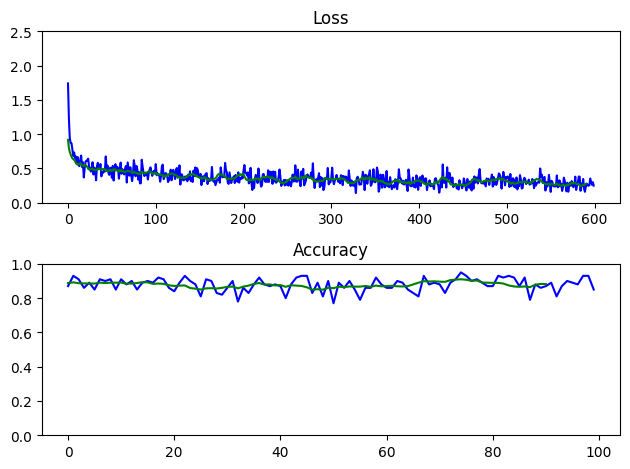

In [51]:
#Plot/Print Metrics
modelMetrics(ignore_batches(baseline_predictions), test_dataset.targets, baseline_loss, baseline_accuracy)
pass #avoid auto-print

## Learning Rate

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83.19%


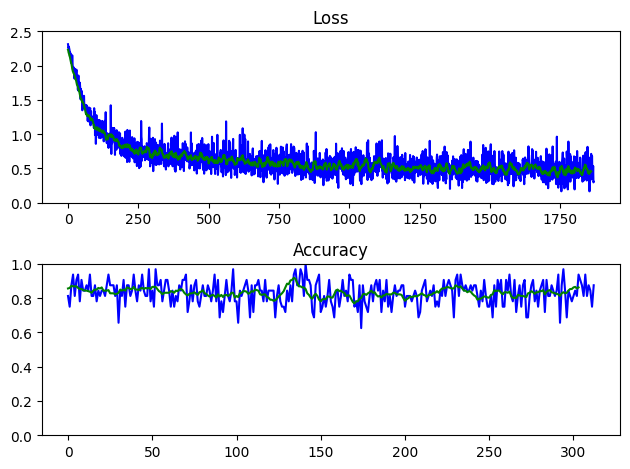

In [ ]:
lr_point00001 = run_experiment(lr=0.00001)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.21%


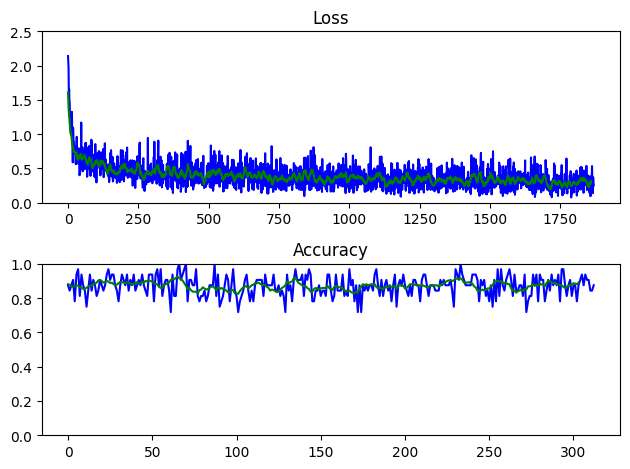

In [ ]:
lr_point0001 = run_experiment(lr=0.0001)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.83%


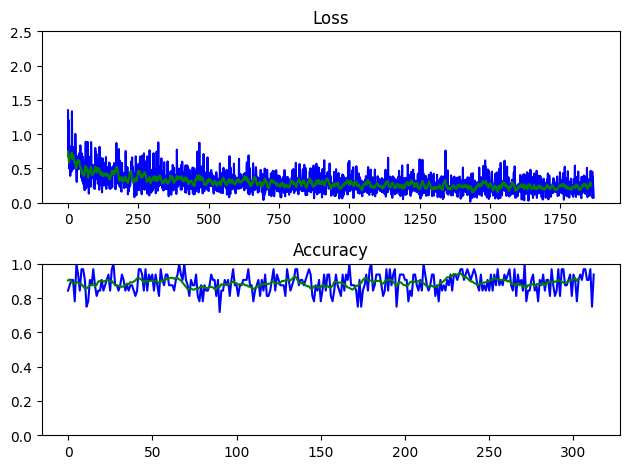

In [ ]:
lr_point001 = run_experiment(lr=0.001)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85.22%


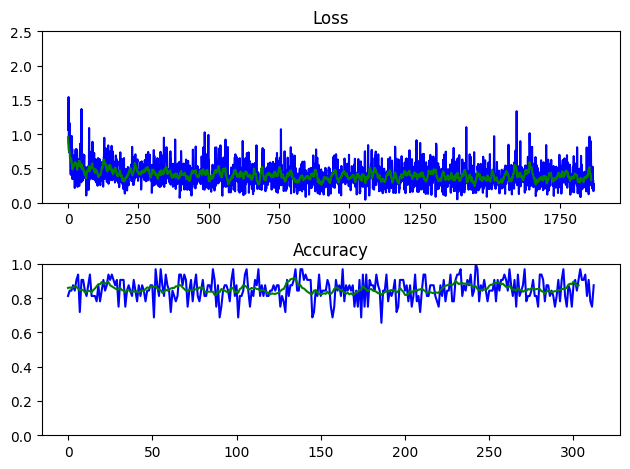

In [ ]:
lr_point01 = run_experiment(lr=0.01)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 40.82%


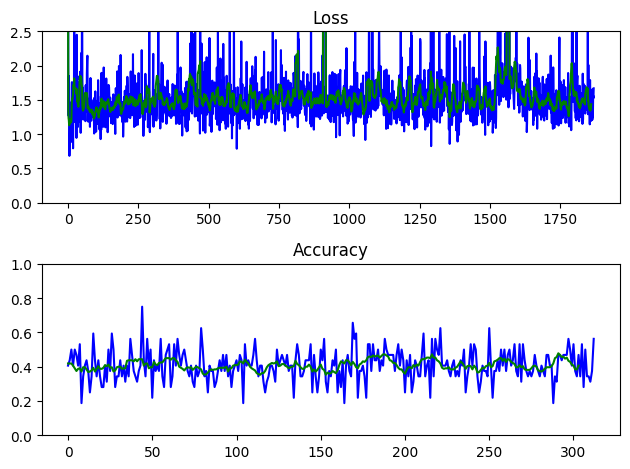

In [ ]:
lr_point1 = run_experiment(lr=0.1)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 10.0%


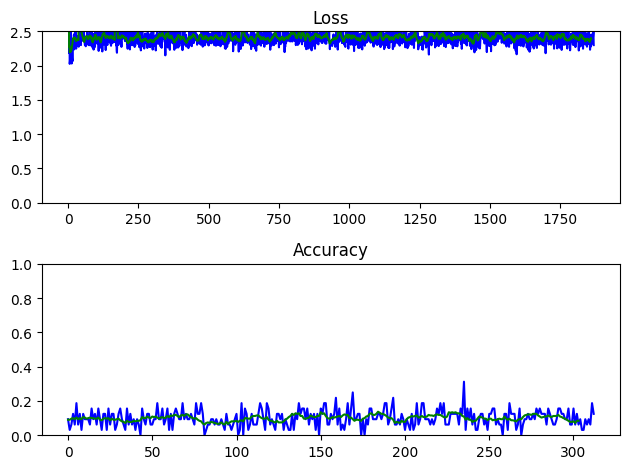

In [ ]:
lr_1 = run_experiment(lr=1)
pass

It appears my testing range goes too high, and such high learning rates likely cause overfitting resulting in shockingly bad accuracy.

From the testing accuracies, it looks like the ideal learning rate is somewhere around 0.001. So I'll investigate a tighter range around this value a bit more

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.87%


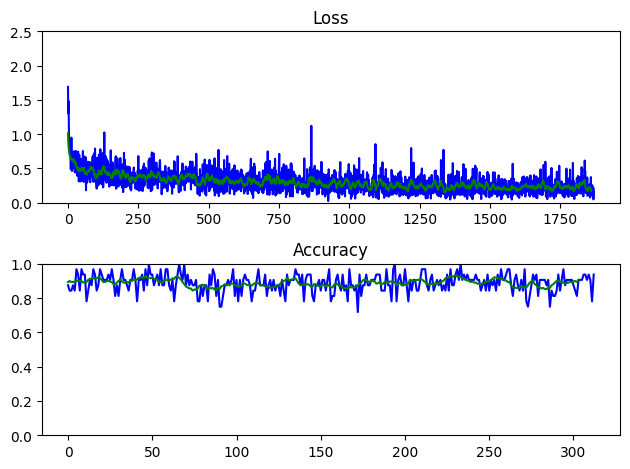

In [ ]:
lr_point0005 = run_experiment(lr=0.0005) #1/2 of 0.001
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 89.05%


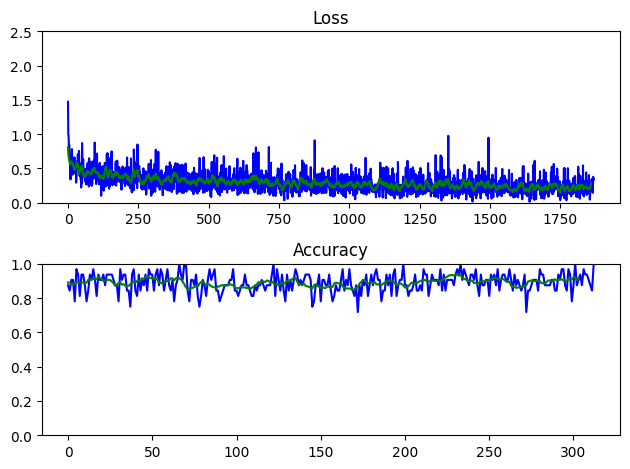

In [ ]:
lr_point00075 = run_experiment(lr=0.00075) #3/4 of 0.001
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.51%


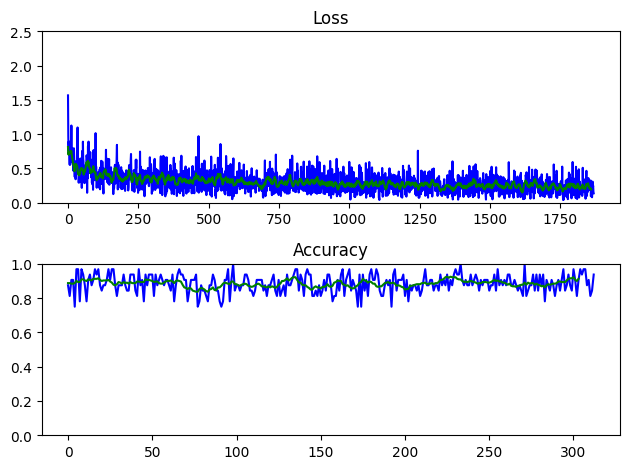

In [ ]:
lr_point0015 = run_experiment(lr=0.0015) #1.5x 0.001
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.5%


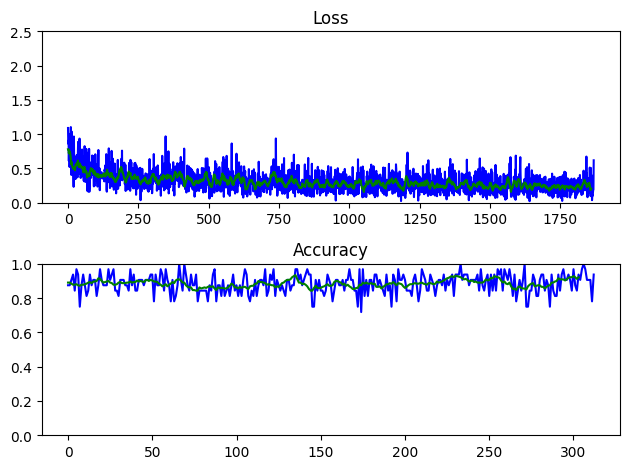

In [ ]:
lr_point002 = run_experiment(lr=0.002) #2x 0.001
pass

Since the difference in these values is within a margin of error, I will continue with the original best value 0.001

## Learning Rate Scheduler
Use best learning rate from above: 0.001

## (Starting) Width

Bearing in mind the input size is 784 (28*28 pixels), and that I automatically scale down each layer

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.23%


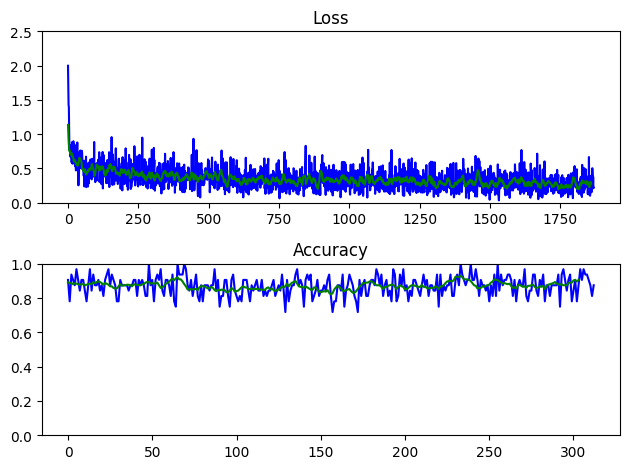

In [ ]:
width_50 = run_experiment(hidden_width=50)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 87.91%


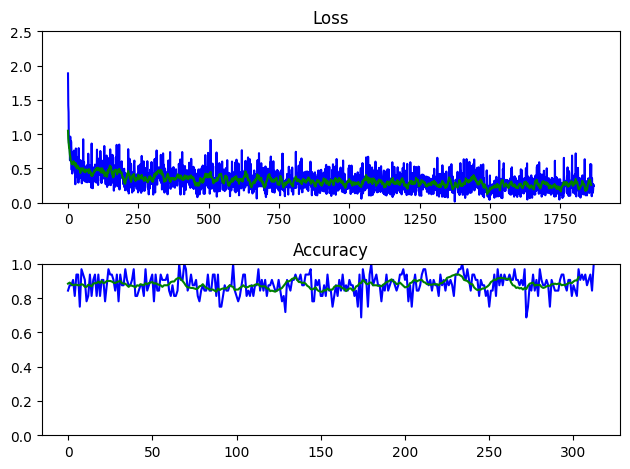

In [ ]:
width_100 = run_experiment(hidden_width=100)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.27%


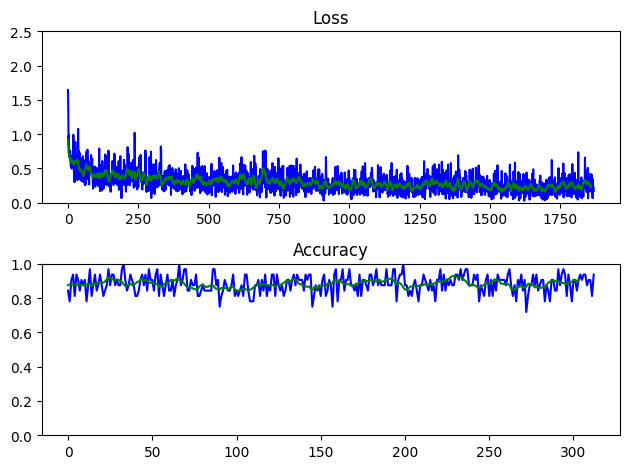

In [ ]:
width_200 = run_experiment(hidden_width=200)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 88.26%


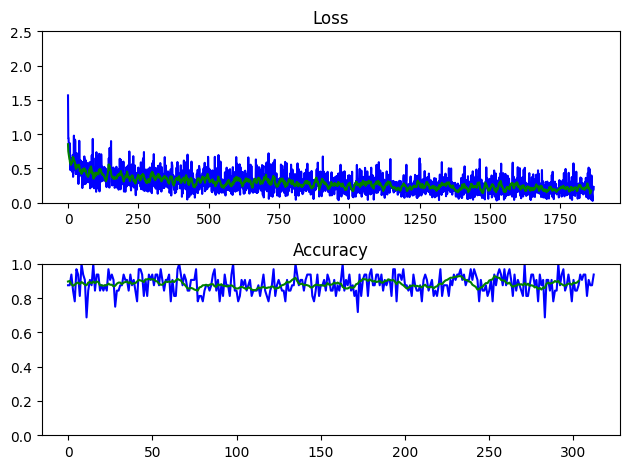

In [ ]:
width_500 = run_experiment(hidden_width=500)
pass

In [ ]:
width_1000 = run_experiment(hidden_width=1000)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

## Depth

In [ ]:
#4 layers
depth_4 = run_experiment(hidden_depth=4)
pass

In [ ]:
#8 layers
depth_8 = run_experiment(hidden_depth=8)
pass

In [ ]:
#16 layers
depth_8 = run_experiment(hidden_depth=16)
pass

In [ ]:
#32 layers
depth_32 = run_experiment(hidden_depth=32)
pass

## Batch Size

In [ ]:
bs_16 = run_experiment(batch_size=16)
pass

In [ ]:
bs_32 = run_experiment(batch_size=32)
pass

In [ ]:
bs_64 = run_experiment(batch_size=64)
pass

In [ ]:
bs_128 = run_experiment(batch_size=128)
pass

In [ ]:
bs_256 = run_experiment(batch_size=256)
pass

**Findings**

The trend I've found is that the greater the batch size, the faster and smoother the loss decreases, but this comes with diminishing returns

## Dropout

TODO: Re-do this with wider/deeper models

Works negatively as dropout only benefits fully connected NNs (by making them less connected), and not convnets

In [ ]:
do_point1 = run_experiment(dropout=0.1)
pass

In [ ]:
do_point2 = run_experiment(dropout=0.2)
pass

In [ ]:
do_point4 = run_experiment(dropout=0.4)
pass

In [ ]:
do_point8 = run_experiment(dropout=0.8)
pass

# Final Model

put together and refine your findings from before

todo: use train/validation split
random search

In [ ]:
#train / validation split
#random_generator = torch.Generator().manual_seed(234558)
#train, val = torch.utils.data.random_split(train_data, [7, 3], generator=random_generator)